In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fancyimpute as imp
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import variation 
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, Lasso, LassoCV
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.decomposition import PCA
from xgboost.sklearn import XGBRegressor
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

Downloaded the Communities and Crime data from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Used the first 1495 rows of data as the training set and the rest as the test set. From the description of the dataset, the first five predictors were not quantitative and not used as predictors to predict Violent Crimes per population size (100k). 

In [2]:
#Reads in names from textfile and performs regex to extract the attribute names 
textfile = open('communities.names.txt','r')
filetext = textfile.read()
textfile.close()
matches = re.findall(r'-{2}\s(\w+)\:{1}', filetext)
col_names = matches[2:] #corresponds to the 128 attributes

In [3]:
#Load the dataset
data = pd.read_csv('communities.data.csv', names = col_names, header = None)
non_pred_cols = ['state','county','community','communityname','fold']
pred_cols = [i for i in col_names if i not in non_pred_cols] #includes all predictor columns names
data_predictive = data[pred_cols] 
data_incomplete = data_predictive.replace('?', np.nan) #replaces all ? with NaN
data_incomplete = data_incomplete.apply(pd.to_numeric, errors='ignore') #converts Numeric strings to int format

In [4]:
goal = ['ViolentCrimesPerPop']
feature_cols = [i for i in pred_cols if i not in goal]
X_incomplete = data_incomplete[feature_cols] #Dataframe with only the features (122)
Y = data_incomplete[goal] #the response variable

In [5]:
def correlation_matrix(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    correlations = data.corr()
    names = data.columns.values.tolist()
    # plot correlation matrix figsize=(size, size)
    fig, ax = plt.subplots()
    cax = ax.matshow(correlations, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(names),1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

The data set has missing values. Therefore, I researched data imputation techniqus and decided to use the mean imputation technique since the features were already normalized to a scale of 0 to 1.

Since the original dataset was normalized between 0 and 1, I decided to use mean imputation to keep the distribution relatively similar to that of the data before imputation.

In [6]:
# Data Imputation using mean of each feature
X_filled = X_incomplete.fillna(X_incomplete.mean())

After calculating the coefficeint of variation for each of the features, we can tell from the histogram below that most of the variations are low, with a small amout that are above 4.

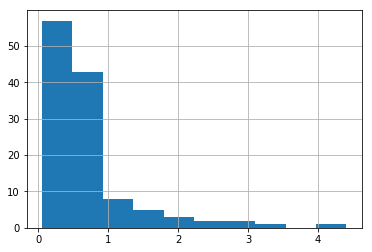

In [8]:
variation = X_filled.std()/X_filled.mean()
variation.hist()

The features with highest CV were chosen and scatter plots and box plots were made. 

In [9]:
N = int(np.sqrt(128))
selected_features = variation.nlargest(n=N).index.tolist()
X_selected = X_filled[selected_features]

In [10]:
# This adds the class label to be the last column in the dataframe
df_new = pd.concat([X_selected, data['ViolentCrimesPerPop']], axis = 1)

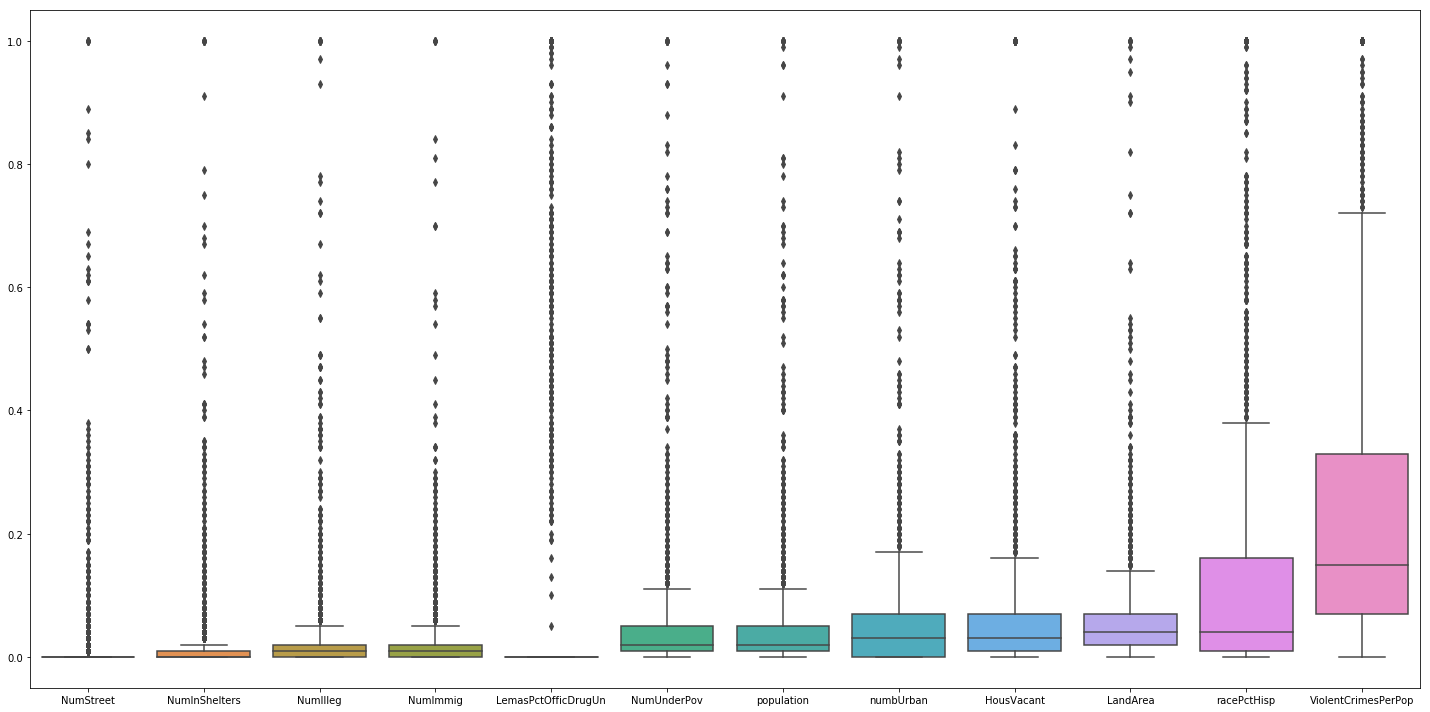

In [11]:
# Boxplots
plt.figure(figsize=(20,10))
ax = sns.boxplot(data = df_new)
boxes = ax.artists
plt.tight_layout()
plt.show()

From the Boxplots above, we can see that the data is heavily skewed towards low values. Since theses features are the predictors with the highest Coefficient of Variation it makes sence that there are outliers in the data as seen from the boxplots. 

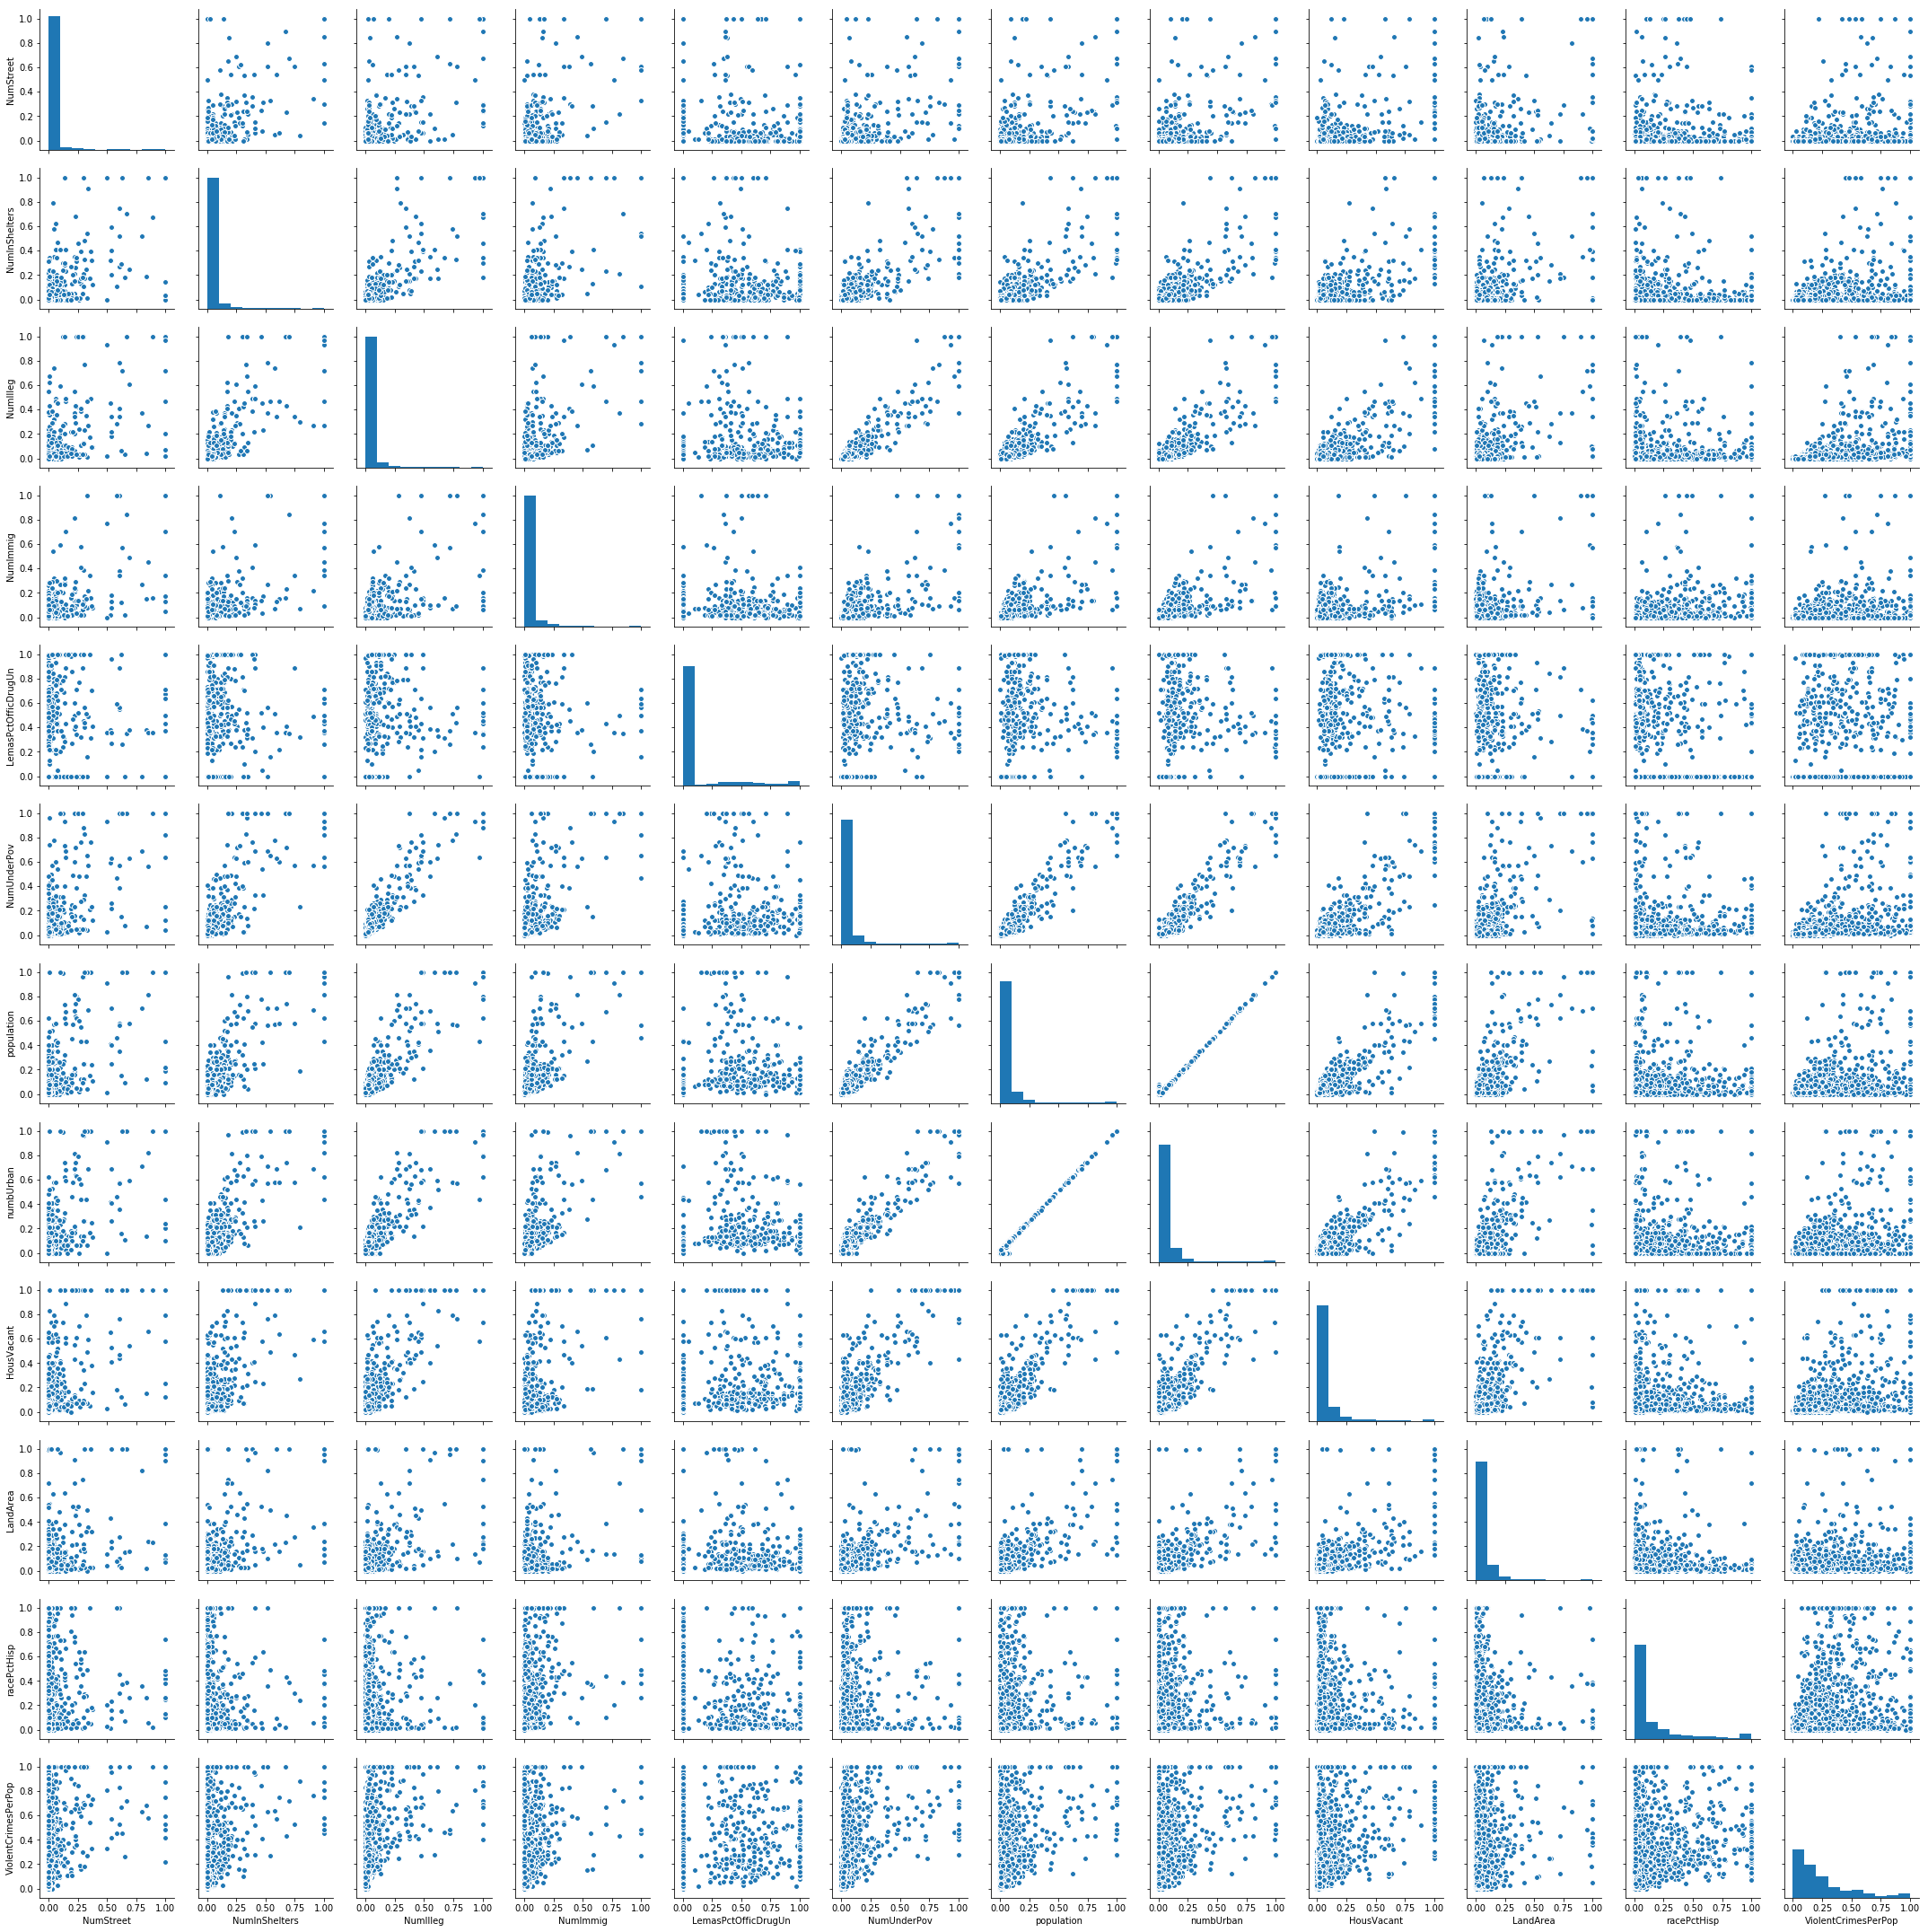

In [12]:
sns.pairplot(df_new)

From the above Scatter plots, we can see that there is a strong linear correlation between the population and the numUrban features, which represent the population of the community and the number of people living in areas classified as urban respectively. Also we can see that many data points for the total number of violent crimes per 100K popuation, are skewed to lower values, meaning that most of the data shows that on average there are a relatively low number crimes per 100k population. 

In [13]:
def train_test_split(X,Y):
    """ Breaks data into training and testing sets 
        Parameters
        ----------
        X : pandas dataframe, frame representing the predictors
        Y : pandas series, series representing the target 
        Results
        ---------
        returns X_train, Y_train, X_test, Y_test
        """
    Y_train = Y[:1495]
    Y_test = Y[1495:]
    X_train = X[:1495]    
    X_test = X[1495:]  
    return X_train, Y_train, X_test, Y_test
        

A linear model was fit using least squares on the training set and the test error was reported.

In [14]:
X_train, Y_train, X_test, Y_test = train_test_split(X_filled, Y)

In [15]:
def LinearReg(X_train, Y_train, X_test, Y_test):
    """ Performs Linear Regression on training and testing sets 
        Parameters
        ----------
        X : pandas dataframe, frame representing the predictors
        Y : pandas series, series representing the target 
        Results
        ---------
        returns X_train, Y_train, X_test, Y_test
        """
    # Create linear regression object
    linreg = LinearRegression()

    # Train the model using the training sets
    linreg.fit(X_train,Y_train)

    # Make predictions using the testing set
    Y_pred = linreg.predict(X_test)

    # The mean squared error
    linreg_mse = metrics.mean_squared_error(Y_test, Y_pred)
    print("Linear Regression Test MSE: %.4f" % linreg_mse)
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % metrics.r2_score(Y_test, Y_pred))

In [16]:
LinearReg(X_train,Y_train,X_test,Y_test)

Linear Regression Test MSE: 0.7897
Variance score: -15.61


In [17]:
y_train = Y_train.ViolentCrimesPerPop #ordering it so below function will work correctly
y_test = Y_test.ViolentCrimesPerPop

Next I fit a ridge regression model on the training set, with regularized variable chosen by cross-validation. The test error was obtained and compared to the test error seen from least squares regression. 

In [18]:
def plot_alphas(alphas, coefs, model, title_param = None):
    """ Plots the regularization parameter along the x-axis vs the weighted coefficients along the y-axis to see how increasing
        the regulariation parameter effects the coefficients
        Parameters
        ----------
        alphas : list, regularization parameters to plot
        coefs : list, coefficients returned after fitting a model 
        model : model object, either Lasso or Ridge Regression
        title_param : str, added to the title name
        Results
        ---------
        returns plot of coefficient weights vs regularization parameter
        """  
    ax = plt.gca()
    if model == 'LASSO':
        ax.plot(alphas*2, coefs)
    elif model == 'Ridge':
        ax.plot(alphas, coefs)
    ax.set_xscale('log')
    plt.axis('tight')
    plt.xlabel('Alpha')
    plt.ylabel('Coefficient Weights')
    
    if title_param == None:
        plt.title(model)
    else:
        plt.title(model + " " + title_param)

Generating an array of alpha values ranging from very big to very small, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit.

In [19]:
alphas = 10**np.linspace(10,-2,100)*0.5

This block of code performs Ridge Regression on different alphas to get the coefficient matrix associated with each so that we can observe how the coefficients change when we increase the regularization term.

In [20]:
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

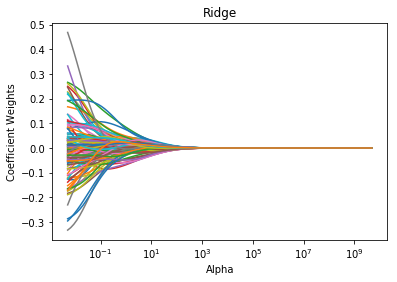

In [21]:
plot_alphas(alphas, coefs, 'Ridge')

As You can see from the graph above, as we increase the regularization parameter the coefficient weights are regularized to values that are close to zero, but are not exactly zero. Next I perform LOOCV as the cross validation technique to choose the optimal regularization parameter, which in this case is alpha.

In [22]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
print('Best Regularization Parameter for Ridge Regression: %.4f' % ridgecv.alpha_)

Best Regularization Parameter for Ridge Regression: 0.0466


Therefore, we see that the value of alpha that results in the smallest cross-validation error is 0.0466. We use this value of alpha to fit a new ridge regression model that we will use on our test set to report on the accuracy of the Ridge model.

In [23]:
ridgebest_cv = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridgebest_cv.fit(X_train, y_train)
mse_ridge = metrics.mean_squared_error(y_test, ridgebest_cv.predict(X_test))
print('Ridge Regression Test MSE: %.4f' % (mse_ridge))

Ridge Regression Test MSE: 0.0176


We can see that the Ridge Regression model significantly lowers the test MSE in comparison to the regular Linear Regresssion model. 

Since I imputed the missing values with the mean value of the given feature distribution for each feature, the data should remain normalized between values of 0 and 1 after imputation. Therefore, when this question asks to perform the given procedure for raw features and normalized features, the results should be the same because the raw features are already normalized. To confirm this, I performed the given procedure for both "raw" data (data created after imputation) and normalized data.

In [24]:
def Lasso_Reg(X_train, y_train, X_test, Y_test, alphas, normalize):
    """ Creates two different Lasso models, one from the raw data and one from normalizing the raw data. The plot_alphas
        function is also called within this function
        Parameters
        ----------
        alphas : list, regularization parameters to plot
        X_train, y_train, X_test, Y_test : pandas dataframes representing the data 
        normalize : bool, value to specify whether to create a model with raw or normalized data
        Results
        ---------
        returns lasso model
        """  
    if normalize:
        lasso = Lasso(max_iter = 10000, normalize = True)
    else:
        lasso = Lasso(max_iter = 10000)
    
    coefs = []
    for a in alphas:
        lasso.set_params(alpha=a)
        lasso.fit(X_train, y_train)
        coefs.append(lasso.coef_)
    
    if normalize:
        plot_alphas(alphas, coefs, 'LASSO', title_param = 'With Normalization')
    else:
        plot_alphas(alphas, coefs, 'LASSO', title_param = 'Without Normalization')
    return lasso

In [25]:
def Lasso_CV(X_train, y_train, X_test, Y_test, normalize, lasso):
    """ Performs cross validation to determine the best regularization term and then uses it to fit a Lasso model 
        and prints the Test MSE along with the features that were selected by the L1 norm regularized model. 
        Parameters
        ----------
        X_train, y_train, X_test, Y_test : pandas dataframes representing the data 
        normalize : bool, value to specify whether to create a model with raw or normalized data
        lasso : model object, used to fit the data to the best regularized term
        Results
        ---------
        returns lasso model
        """  
    if normalize:
        lasso_cv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
    else:
        lasso_cv = LassoCV(alphas = None, cv = 10, max_iter = 100000)
    
    # Cross Validate
    lasso_cv.fit(X_train, y_train) 
    
    # Take best alpha Parameter from cross validation and fit a lasso model and 
    lasso.set_params(alpha=lasso_cv.alpha_) 
    lasso.fit(X_train, y_train)
    lasso_mse = metrics.mean_squared_error(y_test, lasso.predict(X_test))
    
    # Some of the coefficients are now reduced to exactly zero.
    coef_series = pd.Series(lasso.coef_, index=X_train.columns)
    selected_features = coef_series[coef_series != 0].index.tolist()
    
    if normalize:
        print('Best Regularization Parameter for Normalized LASSO: %.4f' % lasso_cv.alpha_)
        print('Normalized LASSO Test MSE: %.4f' % (lasso_mse))
        print('Features selected in Normalized LASSO Model\n')
        print(selected_features)
    else:
        print('Best Regularization Parameter for Raw LASSO: %.4f' % lasso_cv.alpha_)
        print('Raw LASSO Test MSE: %.4f' % (lasso_mse))
        print('Features selected in Raw LASSO Model\n')
        print(selected_features) 
        
    return selected_features

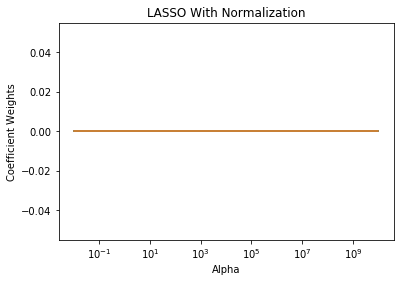

In [26]:
lasso_norm = Lasso_Reg(X_train, y_train, X_test, Y_test, alphas, True)

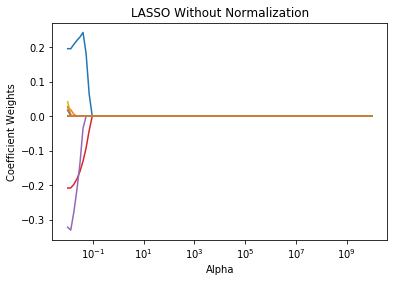

In [27]:
lasso_raw = Lasso_Reg(X_train, y_train, X_test, Y_test, alphas, False)

Notice that in the coefficient plot that depending on the choice of tuning parameter, some of the coefficients are exactly equal to zero. We now perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error for each of the two Lasso models described above

In [28]:
norm_features = Lasso_CV(X_train, y_train, X_test, Y_test, True, lasso_norm)

Best Regularization Parameter for Normalized LASSO: 0.0000
Normalized LASSO Test MSE: 0.0178
Features selected in Normalized LASSO Model

['racepctblack', 'racePctAsian', 'agePct12t21', 'agePct12t29', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctEmploy', 'PctEmplManu', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec10', 'PctRecImmig10', 'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PersPerOccupHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'RentLowQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 

In [29]:
raw_features = Lasso_CV(X_train, y_train, X_test, Y_test, False, lasso_raw)

Best Regularization Parameter for Raw LASSO: 0.0001
Raw LASSO Test MSE: 0.0178
Features selected in Raw LASSO Model

['racepctblack', 'racePctAsian', 'agePct12t21', 'agePct12t29', 'agePct65up', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctBSorMore', 'PctEmploy', 'PctEmplManu', 'PctOccupManu', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec10', 'PctRecImmig10', 'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PersPerOccupHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'RentLowQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 

In [30]:
print("Number of Variables included in Normalized Model: %s" % len(norm_features))
print("Number of Variables included in Raw Model: %s\n" % len(raw_features))
# Variables in norm LASSO model not in raw LASSO model
var_in_norm = [i for i in norm_features if i not in raw_features] 
# Variables in raw LASSO model not in norm LASSO model
var_not_norm = [i for i in raw_features if i not in norm_features]
print("Variables included in Normalized Lasso Model not included in Raw Lasso Model")
print(var_in_norm)
print("Variables included in Raw Lasso Model not included in Normalized Lasso Model")
print(var_not_norm)

Number of Variables included in Normalized Model: 73
Number of Variables included in Raw Model: 77

Variables included in Normalized Lasso Model not included in Raw Lasso Model
['PctPolicWhite', 'PolicCars']
Variables included in Raw Lasso Model not included in Normalized Lasso Model
['agePct65up', 'PctBSorMore', 'PctOccupManu', 'OwnOccLowQuart', 'PctBornSameState', 'LemasPctOfficDrugUn']


The Test MSE for the LASSO model with "raw" data and the LASSO model with normalized data are exactly the same, which confirms the assertion made earlier. In addition, I checked to see if there were any differences in the variables that were selected for each respective model. It seems like the LASSO Model with normalized data had more variable selection that that of the model with the RAW data. This could make the LASSO Model with normalized data more appealing since the complexity is reduced, while still acheiving a good test MSE.

First we scale the data before we perform Principal Component analysis on the training dataset. Below I print out the first few variables of the first few principal components.

In [31]:
pca = PCA()
X_reduced_train = pca.fit_transform(scale(X_train))

In [32]:
pd.DataFrame(pca.components_.T).loc[:4,:5] #printing out data of first few principal components

,0,1,2,3,4,5
0,0.062789,0.105398,0.195802,0.040858,0.065973,-0.159550
1,-0.005253,0.109635,-0.158170,0.103138,0.192052,0.064809
2,0.107611,0.006035,0.066759,-0.024307,-0.031186,0.065911
3,-0.117151,-0.110901,0.015246,-0.006079,0.039249,-0.034378
4,-0.043320,0.161301,-0.022916,-0.050713,-0.056077,-0.045151


Now we perform 10-fold cross validation on the training set to determine the number of principal components (M) that produces the lowest cross val MSE.

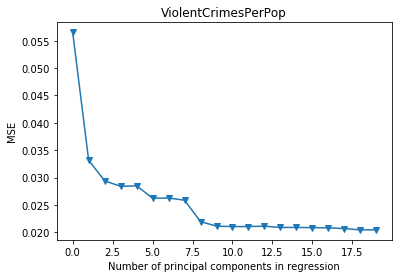

In [33]:
# 10-fold CV, with shuffle
n = len(X_reduced_train)
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*model_selection.cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('ViolentCrimesPerPop')
plt.xlim(xmin=-1);

From the graph above we can see that the number of principal components that has the smallest cross validation MSE is M=9, then the MSE starts to flatten. Next we perform PCA on the training dataset and only consider the values of the first 9 principal components in our regression model.

In [34]:
X_reduced_test = pca.transform(scale(X_test))[:,:9]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:9], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mse = metrics.mean_squared_error(y_test, pred)
print('PCR Test MSE: %.4f' % (mse))

PCR Test MSE: 0.0181


The test set MSE is competitive with the results obtained using ridge regression and the lasso. However, as a result of the way PCR is implemented, the final model is not as interpretable as those obtained with ridge regression or lasso because it does not perform any kind of variable selection or even directly produce coefficient estimates.

Next, I test to see if XGbBoost regression would result in a better test error than the methods tested previously. 

In [35]:
alphas = (10**np.linspace(10,-2,100)*0.5).tolist()

In [36]:
# Grid Search Params
params = {
    'reg_alpha': alphas,   
}
# Initialize XGB and GridSearch
xgbReg = XGBRegressor(nthread= 4, objective= 'reg:linear') 

grid = GridSearchCV(estimator = xgbReg, param_grid = params, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [5000000000.0, 3782316637.773145, 2861183829.67511, 2164380640.5415306, 1637274581.438866, 1238538177.995857, 936908711.4301934, 708737081.4634038, 536133611.00516266, 405565415.3948445, 306795363.6706582, 232079441.68063864, 175559586.71075636, 132804389.1473342, 100461650....2747, 0.015269277544167062, 0.01155064850041579, 0.008737642000038414, 0.006609705742330144, 0.005]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [37]:
best_l1 = list(grid.best_params_.values())[0] #Best regularization parameter from 5 fold cv above
print('Best L1 Regularization Parameter for XGBoost: %.4f' % best_l1)

Best L1 Regularization Parameter for XGBoost: 0.3290


In [38]:
gbm = XGBRegressor(reg_alpha = best_l1)
gbm.fit(X_train,y_train)
predictions = gbm.predict(X_test)
XGBoost_mse = metrics.mean_squared_error(y_test, predictions)
print('XGBoost Test MSE: %.4f' % (XGBoost_mse))

XGBoost Test MSE: 0.0163


I used GridSearchCV with a 5-fold cross validation parameter to determine the best L1 regularization parameter, then used that to fit an XGBoost model. The test MSE for the XGBoost turned out to be the lowest indicated that this model perfromed the best on the regression task for this problem